Full Purchase Behaviour Data Summary:
        LYLTY_CARD_NBR
count    7.263700e+04
mean     1.361859e+05
std      8.989293e+04
min      1.000000e+03
25%      6.620200e+04
50%      1.340400e+05
75%      2.033750e+05
max      2.373711e+06
Outliers in Purchase Behaviour Data Summary:
        LYLTY_CARD_NBR
count    3.400000e+01
mean     1.997810e+06
std      6.343002e+05
min      8.619210e+05
25%      2.330034e+06
50%      2.330261e+06
75%      2.360126e+06
max      2.373711e+06
Full Transaction Data Summary:
                 DATE     STORE_NBR  LYLTY_CARD_NBR        TXN_ID  \
count  264836.000000  264836.00000    2.648360e+05  2.648360e+05   
mean    43464.036260     135.08011    1.355495e+05  1.351583e+05   
std       105.389282      76.78418    8.057998e+04  7.813303e+04   
min     43282.000000       1.00000    1.000000e+03  1.000000e+00   
25%     43373.000000      70.00000    7.002100e+04  6.760150e+04   
50%     43464.000000     130.00000    1.303575e+05  1.351375e+05   
75%     435

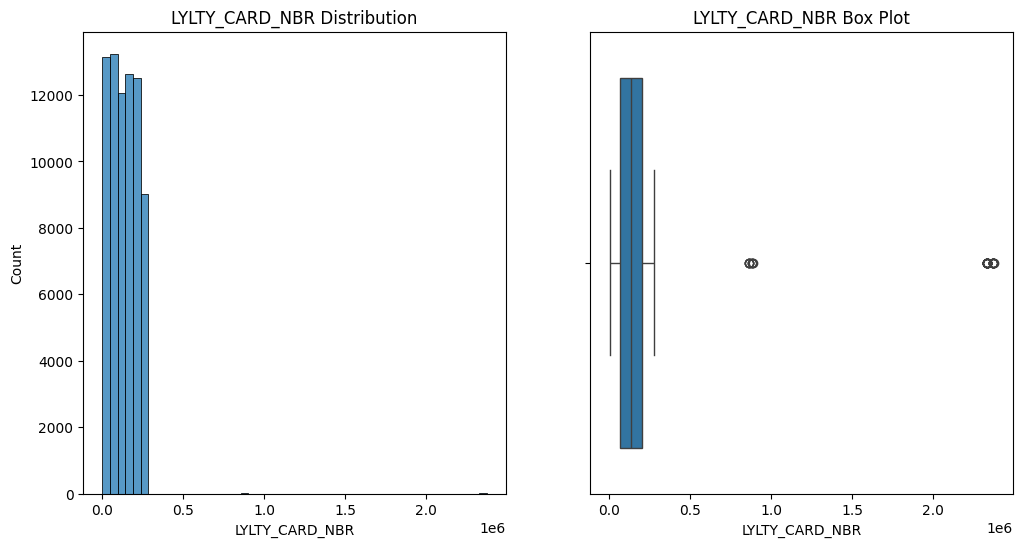

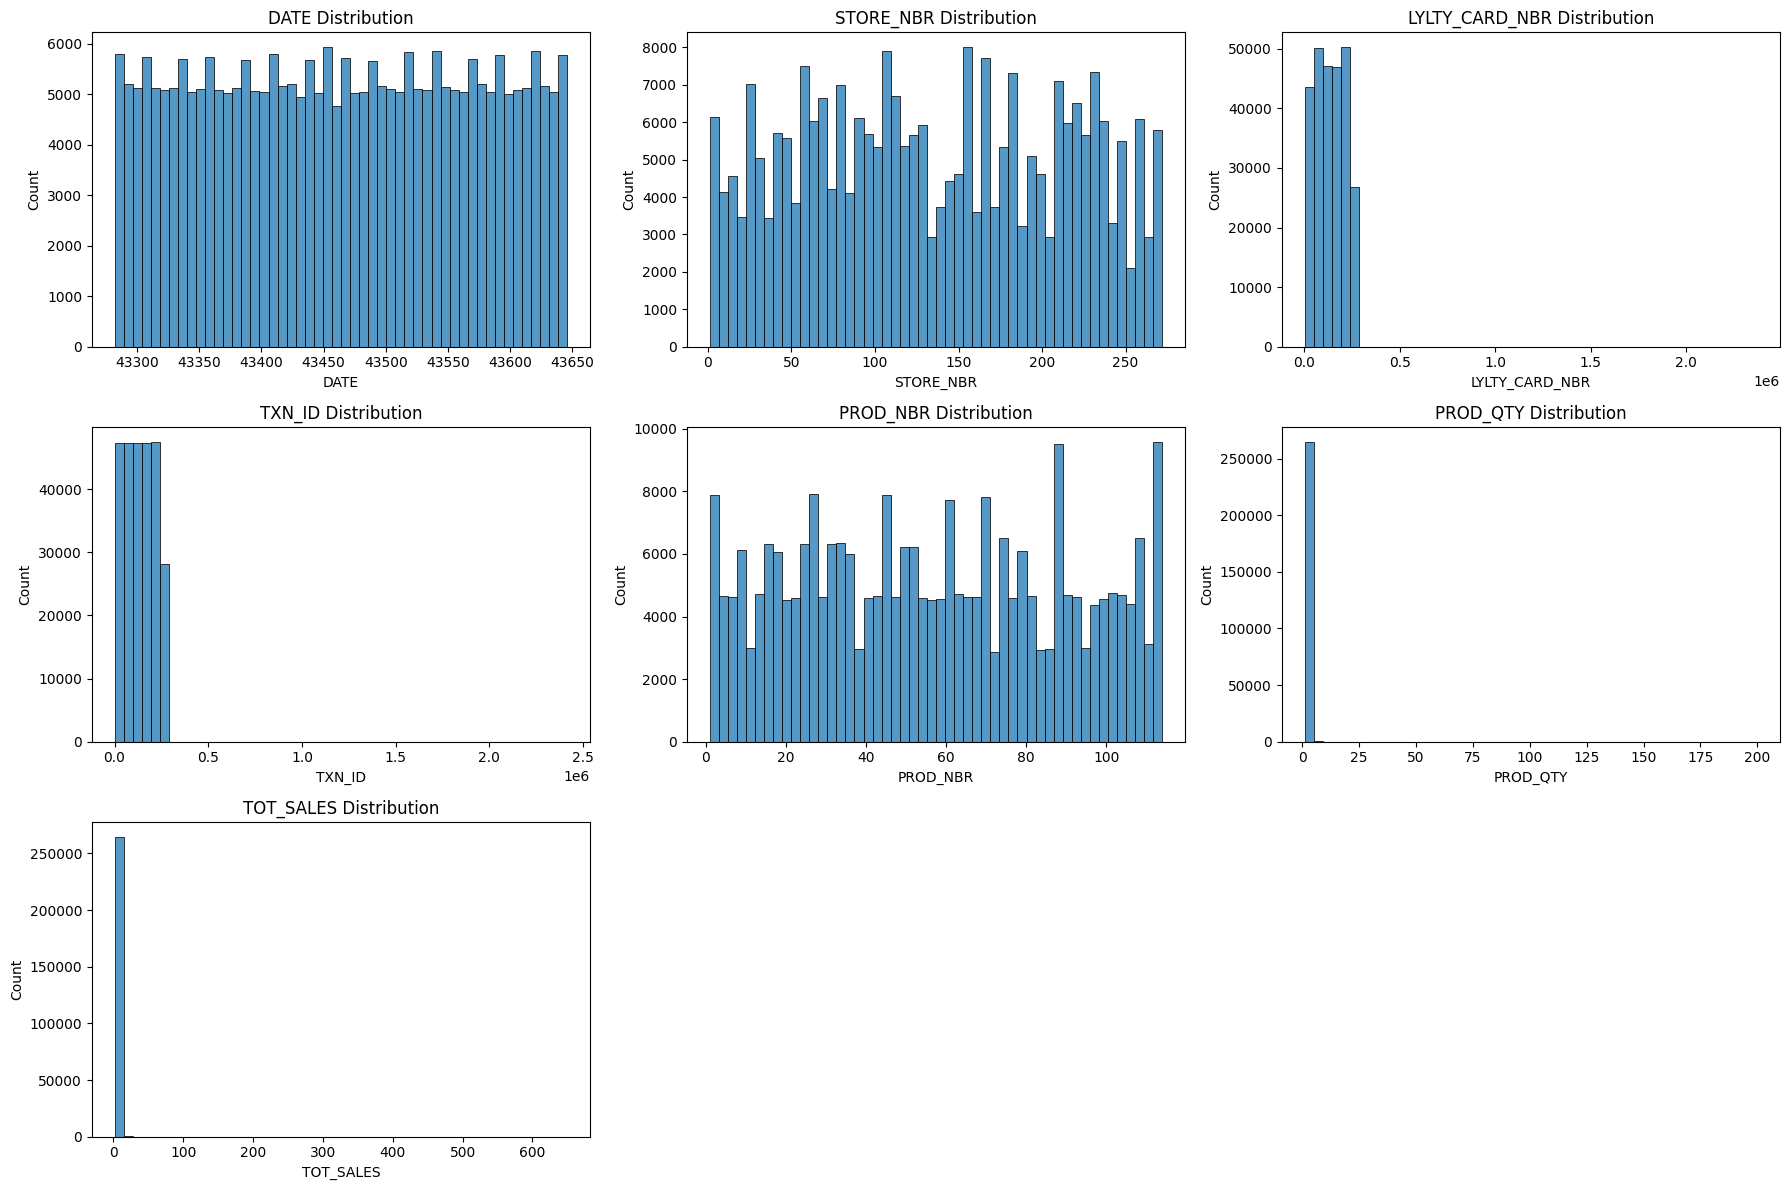

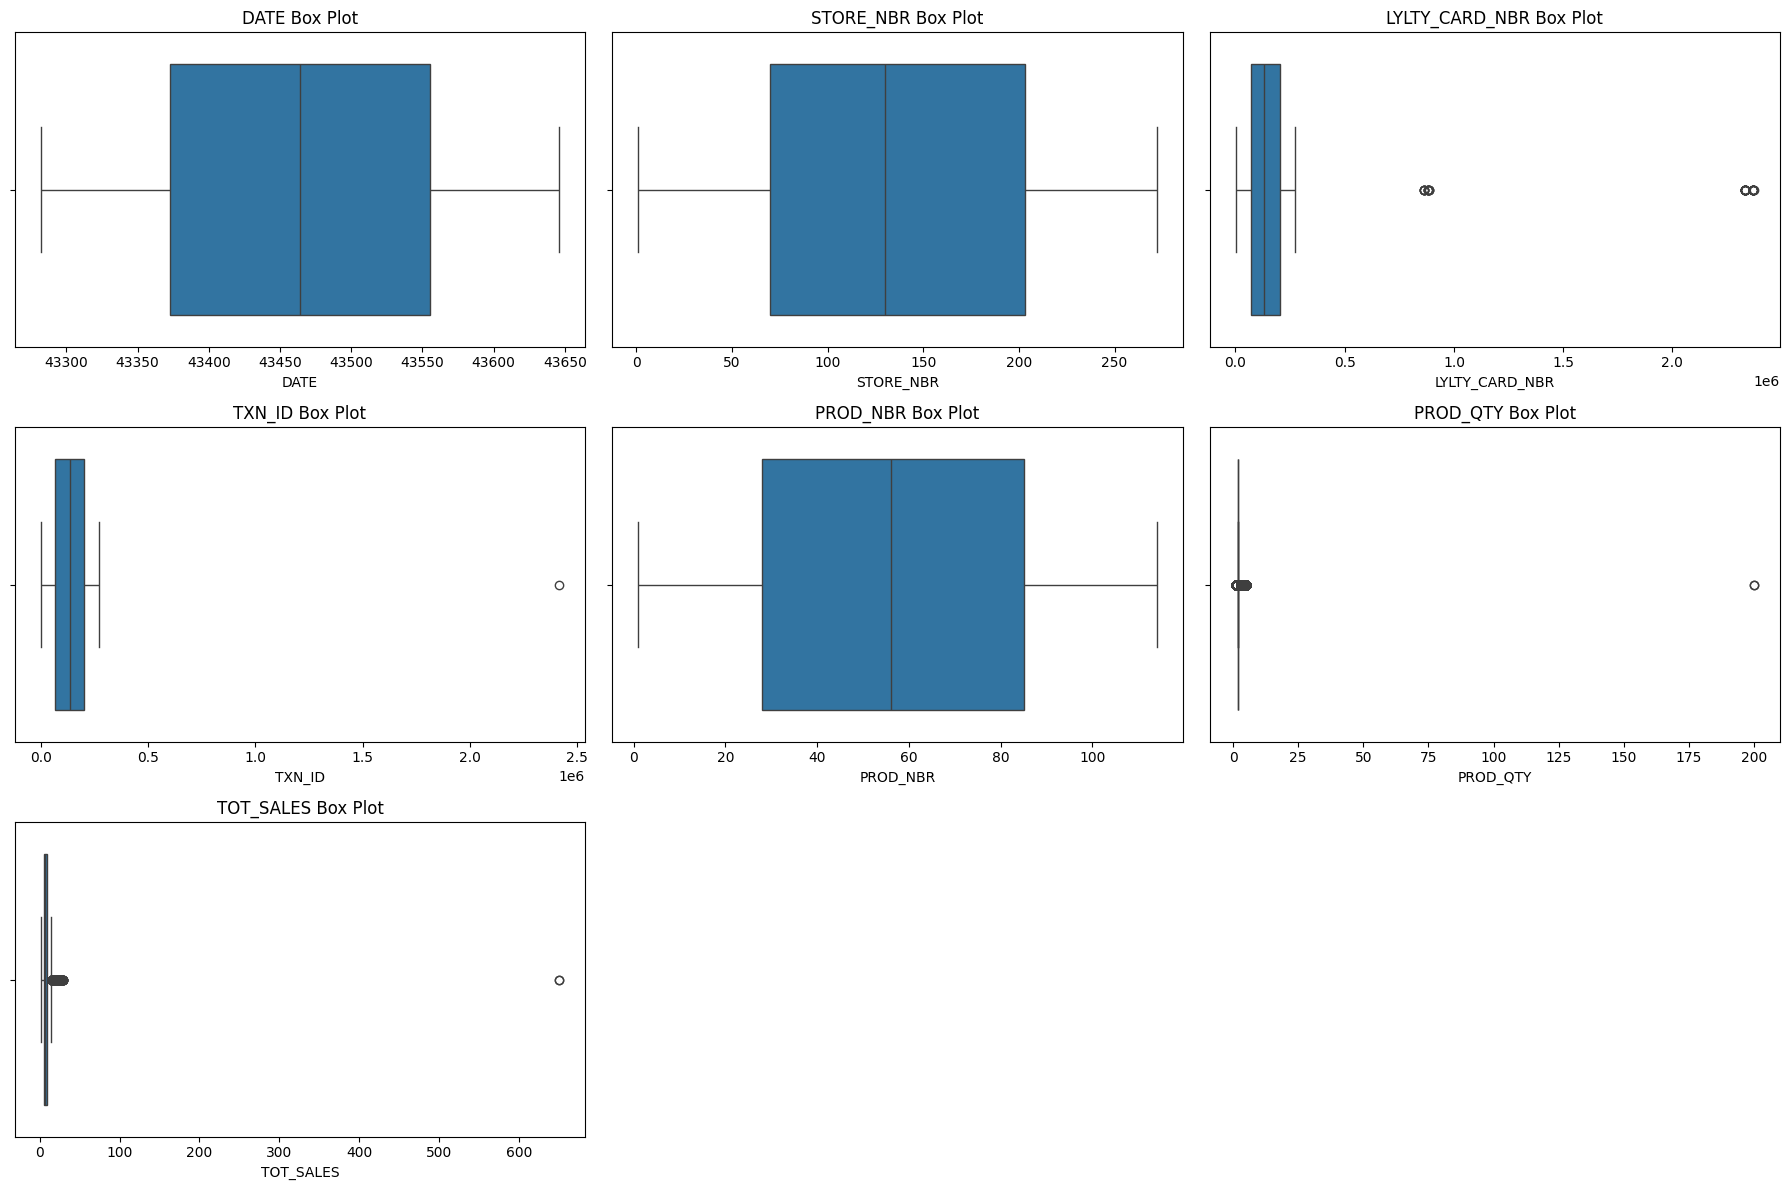

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
purchase_behaviour_data = pd.read_csv('QVI_purchase_behaviour.csv')
transaction_data = pd.read_excel('QVI_transaction_data.xlsx', sheet_name='in')

# Function to identify outliers using Z-score
def z_score_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data.select_dtypes(include=np.number)))
    outliers = (z_scores > threshold).any(axis=1)
    return data[outliers]

# Identify outliers
purchase_behaviour_data_outliers = z_score_outliers(purchase_behaviour_data)
transaction_data_outliers = z_score_outliers(transaction_data)

# Statistical summary
print("Full Purchase Behaviour Data Summary:\n", purchase_behaviour_data.describe())
print("Outliers in Purchase Behaviour Data Summary:\n", purchase_behaviour_data_outliers.describe())

print("Full Transaction Data Summary:\n", transaction_data.describe())
print("Outliers in Transaction Data Summary:\n", transaction_data_outliers.describe())

# Visual inspection
# Purchase Behaviour Data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(purchase_behaviour_data['LYLTY_CARD_NBR'], bins=50)
plt.title('LYLTY_CARD_NBR Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(x=purchase_behaviour_data['LYLTY_CARD_NBR'])
plt.title('LYLTY_CARD_NBR Box Plot')
plt.show()

# Transaction Data
numeric_cols = ['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR', 'PROD_QTY', 'TOT_SALES']

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(transaction_data[col], bins=50)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=transaction_data[col])
    plt.title(f'{col} Box Plot')

plt.tight_layout()
plt.show()
